In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print("Using device:", device)

Using device: mps


In [2]:
def laplacian_1d(u, dx):
    """1D Laplacian with periodic BC."""
    u_left = np.roll(u, 1)
    u_right = np.roll(u, -1)
    return (u_left + u_right - 2*u) / dx**2

def allen_cahn_step_1d(u, eps, dt, dx):
    """One Euler step of 1D Allen–Cahn."""
    lap = laplacian_1d(u, dx)
    nonlinear = u**3 - u
    du_dt = eps**2 * lap - nonlinear
    return u + dt * du_dt

def simulate_ac_1d(u0, eps, dt, dx, n_steps, save_every=1):
    """
    Simulate Allen–Cahn from u0 and return snapshots every save_every steps.
    Returns array of shape (T, N).
    """
    u = u0.copy()
    snaps = [u.copy()]
    for step in range(1, n_steps + 1):
        u = allen_cahn_step_1d(u, eps, dt, dx)
        if step % save_every == 0:
            snaps.append(u.copy())
    return np.stack(snaps)

In [4]:
# Grid & time
N = 256
dx = 1.0 / (N - 1)
dt = 1e-3

# Allen–Cahn parameters for data generation
eps_list = [0.03, 0.06, 0.001]   # different smoothness regimes
n_ic_per_eps = 12              # number of different initial conditions per eps
n_steps = 4000                 # steps per trajectory
save_every = 20                # we save every k steps

print("dx:", dx)

rng = np.random.default_rng(123)

def random_ic_pm1(N, noise_level=0.1):
    """
    Random ±1 domains with some Gaussian noise.
    This gives rich AC patterns after evolution.
    """
    u0 = np.sign(rng.normal(size=N))
    u0 += noise_level * rng.normal(size=N)
    return u0.astype(np.float32)


data_fields = []
data_eps = []

for eps in eps_list:
    print(f"Generating data for eps={eps}...")
    for _ in range(n_ic_per_eps):
        u0 = random_ic_pm1(N)
        traj = simulate_ac_1d(u0, eps, dt, dx, n_steps, save_every=save_every)
        # Drop very early frames if you want mainly "mature" patterns:
        # e.g., skip first 5 frames
        for snap in traj[5:]:
            data_fields.append(snap.astype(np.float32))
            data_eps.append(eps)

data_fields = np.stack(data_fields)   # (M, N)
data_eps = np.array(data_eps, dtype=np.float32)  # (M,)

print("Total snapshots:", data_fields.shape[0])

dx: 0.00392156862745098
Generating data for eps=0.03...
Generating data for eps=0.06...
Generating data for eps=0.001...
Total snapshots: 7056


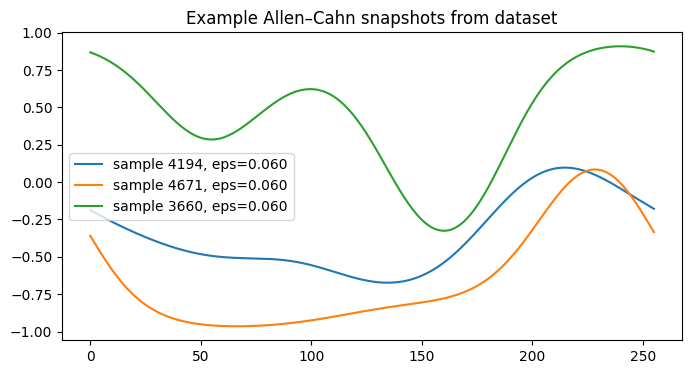

In [5]:
plt.figure(figsize=(8,4))
for i in range(3):
    idx = rng.integers(0, data_fields.shape[0])
    plt.plot(data_fields[idx], label=f"sample {idx}, eps={data_eps[idx]:.3f}")
plt.legend()
plt.title("Example Allen–Cahn snapshots from dataset")
plt.show()

In [6]:
class ACGFMDataset(Dataset):
    """
    Generative FM dataset:
    each item gives a target sample x1 and its epsilon.
    x0 (Gaussian) and t are sampled in the training loop.
    """
    def __init__(self, fields, eps_array):
        self.fields = fields  # (M, N)
        self.eps = eps_array  # (M,)

        self.max_eps = np.max(self.eps)

    def __len__(self):
        return self.fields.shape[0]

    def __getitem__(self, idx):
        x1 = self.fields[idx]              # (N,)
        eps = self.eps[idx]               # scalar
        # Normalize epsilon to [0,1] for conditioning:
        eps_norm = eps / self.max_eps

        return {
            "x1": torch.from_numpy(x1),                    # (N,)
            "eps": torch.tensor([eps_norm], dtype=torch.float32),  # (1,)
        }

gfm_dataset = ACGFMDataset(data_fields, data_eps)
gfm_loader = DataLoader(gfm_dataset, batch_size=64, shuffle=True)

len(gfm_dataset)

7056

In [7]:
class FlowMLP1D(nn.Module):
    def __init__(self, N, hidden_size=512, num_layers=6, cond_dim=64):
        super().__init__()
        self.N = N

        # Embedding for (t, eps)
        self.cond_embed = nn.Sequential(
            nn.Linear(2, cond_dim),
            nn.SiLU(),
            nn.Linear(cond_dim, cond_dim),
            nn.SiLU()
        )

        in_dim = N + cond_dim
        layers = [nn.Linear(in_dim, hidden_size),
                  nn.LayerNorm(hidden_size),
                  nn.SiLU()]

        for _ in range(num_layers - 1):
            layers.append(nn.Linear(hidden_size, hidden_size))
            layers.append(nn.LayerNorm(hidden_size))
            layers.append(nn.SiLU())
            layers.append(nn.Dropout(0.1))

        layers.append(nn.Linear(hidden_size, N))

        self.net = nn.Sequential(*layers)

    def forward(self, x_t, t, eps):
        """
        x_t: (B, N)
        t:   (B, 1)
        eps: (B, 1) normalized
        """
        cond = torch.cat([t, eps], dim=1)           # (B, 2)
        cond_emb = self.cond_embed(cond)            # (B, cond_dim)
        inp = torch.cat([x_t, cond_emb], dim=1)     # (B, N+cond_dim)
        v = self.net(inp)                           # (B, N)
        return v

In [8]:
model = FlowMLP1D(N=N).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [16]:
def train_gfm_epoch(model, loader, optimizer):
    model.train()
    total_loss = 0.0
    n_batches = 0

    for batch in loader:
        x1 = batch["x1"].to(device)         # (B, N)
        eps = batch["eps"].to(device)       # (B, 1)

        B = x1.shape[0]

        # Sample x0 ~ N(0, I)
        x0 = torch.randn_like(x1)           # (B, N)

        # Sample t ~ U[0,1]
        t = torch.rand(B, 1, device=device) # (B, 1)

        # Linear conditional path
        x_t = (1.0 - t) * x0 + t * x1       # (B, N)

        # Target conditional velocity (simple linear path)
        v_target = (x1 - x0)                # (B, N)

        # Predict velocity
        v_pred = model(x_t, t, eps)         # (B, N)

        loss = F.mse_loss(v_pred, v_target)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        n_batches += 1

    return total_loss / max(n_batches, 1)

# --- Train for a few epochs ---
n_epochs = 300
loss_hist = []

for epoch in range(1, n_epochs+1):
    avg_loss = train_gfm_epoch(model, gfm_loader, optimizer)
    loss_hist.append(avg_loss)
    print(f"Epoch {epoch}/{n_epochs} - Loss: {avg_loss:.6f}")

Epoch 1/300 - Loss: 1.077225
Epoch 2/300 - Loss: 1.071524
Epoch 3/300 - Loss: 1.074815
Epoch 4/300 - Loss: 1.069345
Epoch 5/300 - Loss: 1.068176
Epoch 6/300 - Loss: 1.071351
Epoch 7/300 - Loss: 1.069678
Epoch 8/300 - Loss: 1.070080
Epoch 9/300 - Loss: 1.067369
Epoch 10/300 - Loss: 1.066714
Epoch 11/300 - Loss: 1.063935
Epoch 12/300 - Loss: 1.067589
Epoch 13/300 - Loss: 1.062405
Epoch 14/300 - Loss: 1.065304
Epoch 15/300 - Loss: 1.066854
Epoch 16/300 - Loss: 1.062945
Epoch 17/300 - Loss: 1.062028
Epoch 18/300 - Loss: 1.063583
Epoch 19/300 - Loss: 1.062393
Epoch 20/300 - Loss: 1.061284
Epoch 21/300 - Loss: 1.065486
Epoch 22/300 - Loss: 1.057589
Epoch 23/300 - Loss: 1.058610
Epoch 24/300 - Loss: 1.061723
Epoch 25/300 - Loss: 1.058279
Epoch 26/300 - Loss: 1.053329
Epoch 27/300 - Loss: 1.058413
Epoch 28/300 - Loss: 1.057581
Epoch 29/300 - Loss: 1.056930
Epoch 30/300 - Loss: 1.052464
Epoch 31/300 - Loss: 1.052130
Epoch 32/300 - Loss: 1.052787
Epoch 33/300 - Loss: 1.051167
Epoch 34/300 - Loss

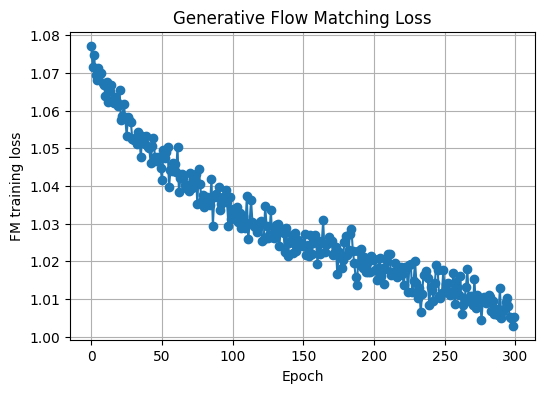

In [17]:
plt.figure(figsize=(6,4))
plt.plot(loss_hist, marker="o")
plt.xlabel("Epoch")
plt.ylabel("FM training loss")
plt.title("Generative Flow Matching Loss")
plt.grid(True)
plt.show()

In [18]:
def sample_gfm(model, N, eps_value, n_steps=50):
    """
    Sample one field from the generative FM model
    for a given (physical) eps_value.
    """
    model.eval()
    with torch.no_grad():
        # Normalize epsilon as in training
        eps_norm = eps_value / np.max(eps_list)
        eps = torch.tensor([[eps_norm]], dtype=torch.float32, device=device)

        # Sample x0 ~ N(0,I)
        x = torch.randn(1, N, device=device)

        # Time discretization 0→1
        t_vals = torch.linspace(0.0, 1.0, n_steps+1, device=device)

        for k in range(n_steps):
            t_mid = 0.5*(t_vals[k] + t_vals[k+1])   # midpoint time
            t = t_mid.view(1,1)                    # (1,1)
            v = model(x, t, eps)                   # (1,N)
            dt = float(t_vals[k+1] - t_vals[k])
            x = x + dt * v

        return x.cpu().numpy()[0]   # (N,)

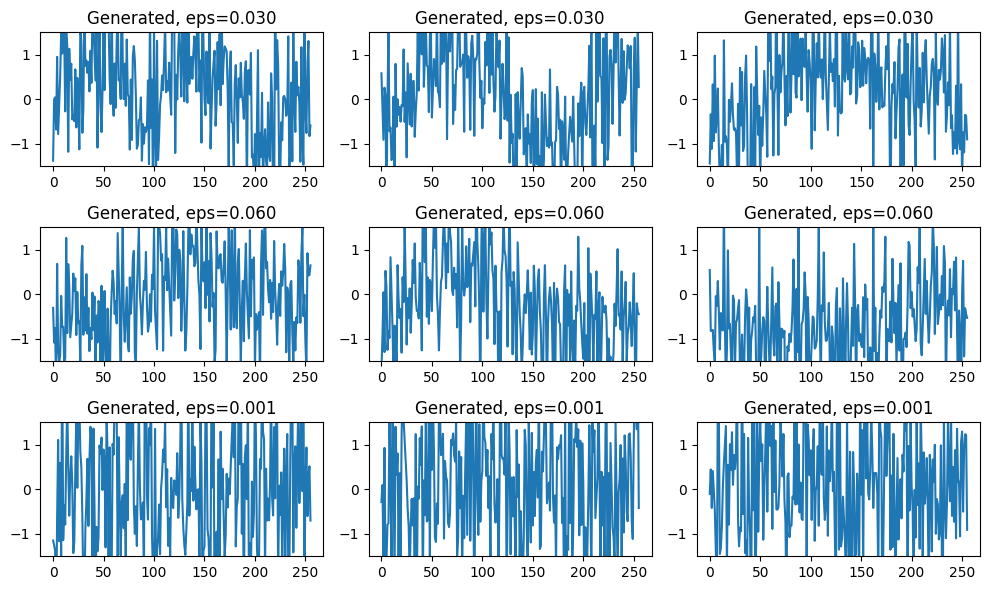

In [19]:
eps_test_values = [0.03, 0.06, 0.001]

plt.figure(figsize=(10,6))
for i, eps_val in enumerate(eps_test_values):
    for j in range(3):
        x_gen = sample_gfm(model, N, eps_val, n_steps=60)
        plt.subplot(len(eps_test_values), 3, i*3 + j + 1)
        plt.plot(x_gen)
        plt.title(f"Generated, eps={eps_val:.3f}")
        plt.ylim(-1.5, 1.5)
plt.tight_layout()
plt.show()

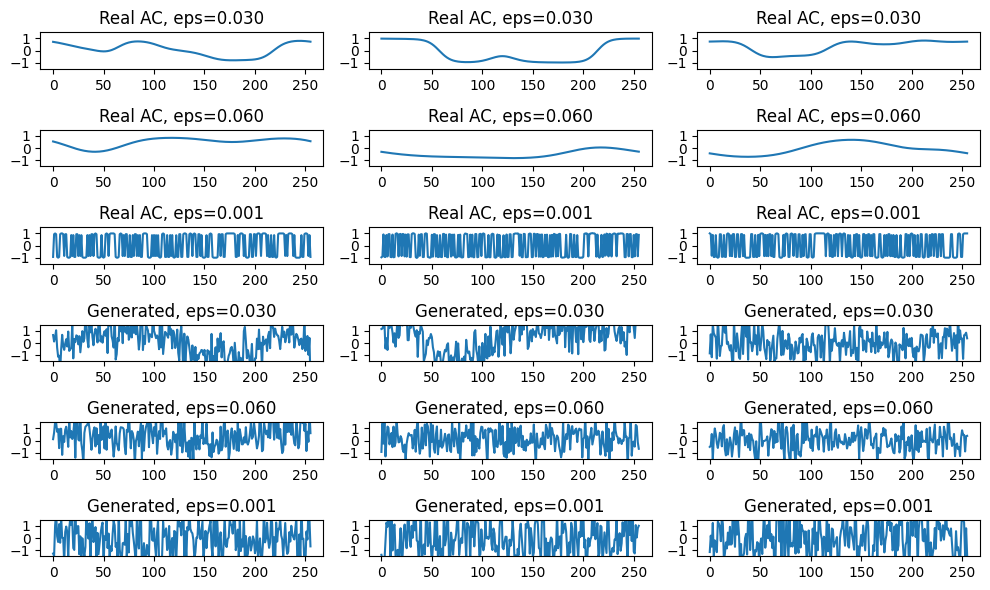

In [20]:
# Pick some random real samples from dataset for comparison
plt.figure(figsize=(10,6))

for i, eps_val in enumerate(eps_test_values):
    # Real samples
    idxs = np.where(np.isclose(data_eps, eps_val, atol=1e-5))[0]
    idxs = rng.choice(idxs, size=3, replace=False)

    for j in range(3):
        plt.subplot(2*len(eps_test_values), 3, i*3 + j + 1)
        plt.plot(data_fields[idxs[j]])
        plt.title(f"Real AC, eps={eps_val:.3f}")
        plt.ylim(-1.5, 1.5)

    # Generated samples
    for j in range(3):
        plt.subplot(2*len(eps_test_values), 3, (i+len(eps_test_values))*3 + j + 1)
        x_gen = sample_gfm(model, N, eps_val, n_steps=60)
        plt.plot(x_gen)
        plt.title(f"Generated, eps={eps_val:.3f}")
        plt.ylim(-1.5, 1.5)

plt.tight_layout()
plt.show()